In [32]:
#필요한 라이브러리를 로드합니다. 
import os
import cv2
import PIL
import math
import skimage
import albumentations
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
1.3.3
8.3.2
0.18.3
1.1.0


In [2]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data_dir = os.getenv('HOME') + '/aiffel/DLton/Polyp_segmentation/'

train_dir = data_dir + 'train'
test_dir = data_dir + 'test'
class_dict_dir = data_dir + 'class_dict.csv'
metadata_dir = data_dir + 'metadata.csv'

In [7]:
class_dict = pd.read_csv(class_dict_dir)
class_dict

,class_names,r,g,b
0,background,0,0,0
1,polyp,255,255,255


In [9]:
metadata = pd.read_csv(metadata_dir)
metadata.head(5)

,frame_id,sequence_id,tif_image_path,tif_mask_path,png_image_path,png_mask_path
0,1,1,TIFF/Original/1.tif,TIFF/Ground Truth/1.tif,PNG/Original/1.png,PNG/Ground Truth/1.png
1,10,1,TIFF/Original/10.tif,TIFF/Ground Truth/10.tif,PNG/Original/10.png,PNG/Ground Truth/10.png
2,100,5,TIFF/Original/100.tif,TIFF/Ground Truth/100.tif,PNG/Original/100.png,PNG/Ground Truth/100.png
3,101,5,TIFF/Original/101.tif,TIFF/Ground Truth/101.tif,PNG/Original/101.png,PNG/Ground Truth/101.png
4,102,5,TIFF/Original/102.tif,TIFF/Ground Truth/102.tif,PNG/Original/102.png,PNG/Ground Truth/102.png


1. Horizontal and vertical flips    
2. Color jitter with a brightness factor uniformly sampled from [0.6, 1.6], a contrast of 0.2, a saturation factor of 0.1, and a hue factor of 0.01    
3. Affine transforms with rotations of an angle sampled uniformly from [−180°, 180°], horizontal and vertical translations each of a magnitude sampled uniformly from [− 0.125, 0.125], scaling of a magnitude sampled uniformly from [0.5, 1.5] and shearing of an angle sampled uniformly from [−22.5°, 22°].

https://albumentations.ai/docs/getting_started/transforms_and_targets/

In [25]:
from albumentations import  HorizontalFlip, VerticalFlip, ColorJitter, Affine, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭(default)
                    VerticalFlip(p=0.5),      # 50%의 확률로 수직대칭(default)
                    ColorJitter(
                        brightness=(0.6, 1.6),# 밝기
                        contrast=0.2,         # 대비 
                        saturation=0.1,       # 채도
                        hue=0.01,             # 색상
                        always_apply=True,
                        ),
                    Affine(
                        rotate=(-180, 180),   # 회전
                        translate_percent=(-0.125, 0.125),  # 사진 이동 비율 // (최소비율 , 최대비율)로 지정하여 사용가능
                        # tranlate_px=[-0.125, 0.125],        # 사진 이동 픽셀 // (최소 픽셀, 최대 픽셀) 
                        # 이거 둘중에 뭐지
                        scale=(0.5, 1.5),     # ("zoom" in/out)
                        shear=(-22.5, 22),    # (move one side of the image, turning a square into a trapezoid)
                                              # 영상의 한쪽을 이동하여 사각형을 사다리꼴로 만듦(기울임)
                        always_apply=True,
                        # interpolation=1,
                        # border_mode=4,
                        # mode='reflect',  # border 처리 방식
                        ),
                    Resize(              # 입력이미지를 256X256로 resize (모델에 맞게 설정)
                        width=256,
                        height=256
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 256X256로 resize만 수행 (모델에 맞게 설정)
                Resize(
                    width=256,
                    height=256
                    )
                ])

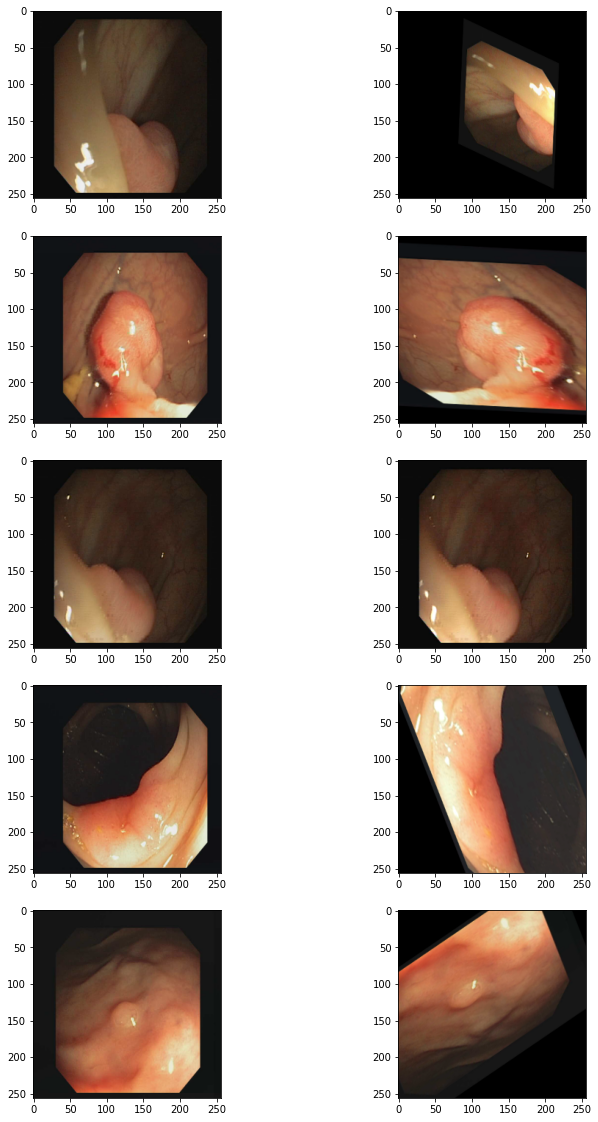

In [21]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(train_dir, "PNG",'Originals', "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

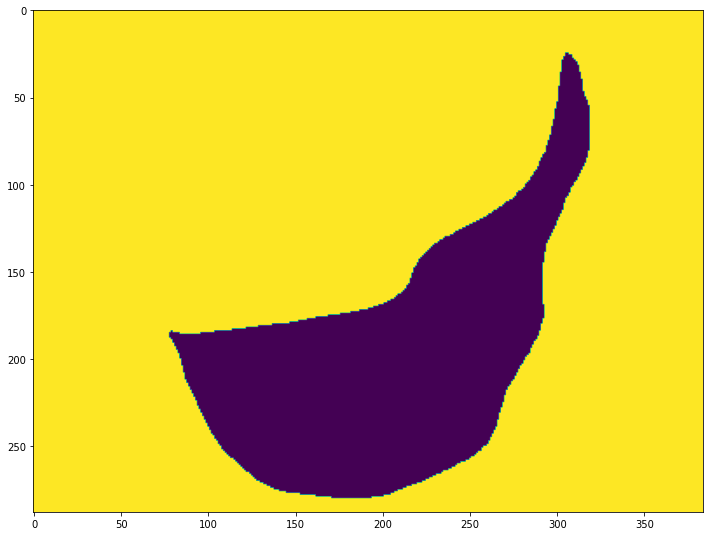

In [42]:
label_test = glob(os.path.join(train_dir, "PNG", 'Ground Truth', "*.png"))

plt.figure(figsize=(12, 20))
i=3
img = imread(label_test[i], as_gray=True) 
_output = (img==0).astype(np.uint8)*1

plt.imshow(_output)  
  
plt.show()

In [28]:
# tf.keras.utils.Sequence 상속
# Sequence를 커스텀해서 사용
# batch_size, img_size, output_size : 모델에 맞춰서 사용하기
class Generator(tf.keras.utils.Sequence):

    def __init__(self, dir_path, batch_size=128, img_size=(256, 256, 3), 
                 output_size=(256, 256), is_train=True, augmentation=None):
        self.dir_path = dir_path 
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation    # 적용할 augmentation 함수를 인자로 받음
        self.img_size = img_size            # preprocess에 사용할 input image size
        self.output_size = output_size      # ground_truth를 만들기 위한 size

        # load_dataset()을 통해서 dataset의 directory path에서 라벨과 이미지를 확인
        self.data = self.load_dataset()

    def load_dataset(self):
    # test set을 분리해서 load
        png_input_images = glob(os.path.join(self.dir_path, "PNG", 'Originals' "*.png"))
        png_label_images = glob(os.path.join(self.dir_path, "PNG", 'Ground Truth' "*.png"))
        tif_input_images = glob(os.path.join(self.dir_path, 'TIF', 'Originals', '*.png'))
        tif_label_images = glob(os.path.join(self.dir_path, 'TIF', 'Ground Truth', '*.png'))
        input_images = png_input_images + tif_input_images
        label_images = png_label_images + tif_label_images
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length
        # 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # input, output 만듦
        # input : resize및 augmentation이 적용된 input image
        # output : semantic label
        batch_data = self.data[
                            index*self.batch_size:
                            (index + 1)*self.batch_size
                            ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            #여기수정
            _output = imread(output_path, as_gray=True)
            _output = (_output==0).astype(np.uint8)*1
            data = {"image": _input,"mask": _output,}
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수
        # 학습중인 경우에 순서를 random shuffle하도록 적용
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [27]:
dir_path = train_dir

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = Generator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = Generator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)